# Testing William fractal strategy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import ta, pickle, json, time

# Import

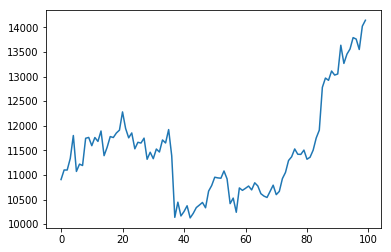

In [26]:
df = pd.read_csv("../data/train1d.csv")
df = pd.read_csv("../data/test1d.csv")
plt.plot(df.open[:100])

In [27]:
def wilFractal(df):
        bear = (
                df['high'].shift(2).lt(df['high']) &
                df['high'].shift(1).lt(df['high']) &
                df['high'].shift(-1).lt(df['high']) &
                df['high'].shift(-2).lt(df['high'])
        )
    
        bull = (
                df['low'].shift(2).gt(df['low']) &
                df['low'].shift(1).gt(df['low']) &
                df['low'].shift(-1).gt(df['low']) &
                df['low'].shift(-2).gt(df['high'])
        )
    
        return bear, bull
    
def ema(df, windows=[20]):
    emas = []
    for x in windows:
        emas.append(
            ta.trend.ema_indicator(close=df.close, window=x, fillna=True)
        )
    return emas

In [28]:
df['bear'], df['bull'] = wilFractal(df)
df['ema20'], df['ema50'], df['ema100'] = ema(df, [20, 50, 100])
df

,timestamp,open,high,low,close,volume,bear,bull,ema20,ema50,ema100
0,2020-07-29,10906.27,11342.82,10812.00,11100.53,76838.094233,False,False,11100.530000,11100.530000,11100.530000
1,2020-07-30,11100.52,11170.00,10831.00,11099.61,60794.826456,False,False,11100.442381,11100.493922,11100.511782
2,2020-07-31,11099.79,11444.00,10960.00,11335.46,70063.660974,False,False,11122.825011,11109.708278,11105.164222
3,2020-08-01,11335.46,11861.00,11220.00,11801.17,85087.485126,False,False,11187.429296,11136.824424,11118.946515
4,2020-08-02,11801.17,12123.46,10518.50,11071.35,97553.077604,True,False,11176.374125,11134.256799,11118.004010
...,...,...,...,...,...,...,...,...,...,...,...
309,2021-06-03,37568.68,39476.00,37170.00,39246.79,75889.106011,True,False,40166.848338,45837.393493,47018.363887
310,2021-06-04,39246.78,39289.07,35555.15,36829.00,91317.799245,False,False,39848.958020,45484.123159,46816.594305
311,2021-06-05,36829.15,37925.00,34800.00,35513.20,70459.621490,False,False,39436.028684,45093.106565,46592.764715
312,2021-06-06,35516.07,36480.00,35222.00,35796.31,47650.206637,False,False,39089.388810,44728.526308,46378.973533


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


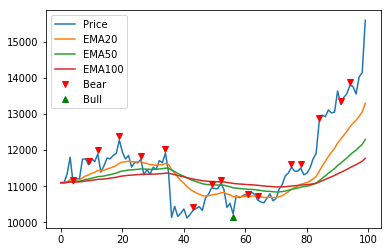

In [29]:
plt.plot(df.close[:100], label='Price')
plt.plot(df.ema20[:100], label='EMA20')
plt.plot(df.ema50[:100], label='EMA50')
plt.plot(df.ema100[:100], label='EMA100')
plt.plot(np.array(range(100))[df.bear[:100]], df.close[:100][df.bear[:100]] + 100, 
         "vr", label='Bear')
plt.plot(np.array(range(100))[df.bull[:100]], df.close[:100][df.bull[:100]] - 100, 
         "^g", label='Bull')
plt.legend()

# Trading

In [30]:
def trade(df, low, high, start):
    ls = df.values.tolist()
    n = len(ls)
    for i in range(n):
        if ls[i][0] > high: # test high
            return high, i
        if ls[i][1] < low: # test low
            return low, i
    return start, n

In [31]:
trades = pd.DataFrame(columns=["i", "timestamp", "Action", "Start", "End", "Benef", "Duration"])
for i in range(len(df)):
    timestamp, o, h, l, c, v, bear, bull, ema20, ema50, ema100 = df.iloc[i]
    if ema20 < ema50 < ema100: # SELL only
        if bear:
            trigger = False
            if ema50 < h < ema100:
                trigger = True
                SL = ema100
            if ema20 < h < ema50:
                trigger = True
                SL = ema50
            if trigger:
                start = df.close[i+2]
                TP = start - 1.5 * (SL - start)
                end, n = trade(df[['high', 'low']][i+2:i+122], TP, SL, start)
                trades = trades.append({
                    "i": i+2,
                    "timestamp" : timestamp,
                    "Action" : "SELL",
                    "Start" : start,
                    "End" : end,
                    "Benef" : start-end,
                    "Duration" : n
                }, ignore_index=True)
    
    if ema20 > ema50 > ema100: # BUY only
        if bull:
            trigger = False
            if ema50 > l > ema100:
                trigger = True
                SL = ema100
            if ema20 > h > ema50:
                trigger = True
                SL = ema50
            if trigger:
                start = df.close[i+2]
                TP = start + 1.5 * (start - SL)
                end, n = trade(df[['high', 'low']][i+2:i+122], SL, TP, start)
                trades = trades.append({
                    "i": i+2,
                    "timestamp" : timestamp,
                    "Action" : "BUY",
                    "Start" : start,
                    "End" : end,
                    "Benef" : end-start,
                    "Duration" : n
                }, ignore_index=True)

In [32]:
trades

,i,timestamp,Action,Start,End,Benef,Duration
0,51,2020-09-16,SELL,10933.39,11133.729572,-200.339572,1
1,63,2020-09-28,SELL,10776.59,11045.038894,-268.448894,9
2,66,2020-10-01,SELL,10542.06,11027.502661,-485.442661,6
3,137,2020-12-11,BUY,19174.99,22880.130275,3705.140275,4
4,216,2021-02-28,BUY,48440.65,58173.893349,9733.243349,11
5,241,2021-03-25,BUY,55817.14,64415.911597,8598.771597,18
6,276,2021-04-29,BUY,57800.37,49682.713173,-8117.656827,11


In [33]:
trades.mean()

i             150.000000
Start       30497.884286
End         32622.702789
Benef        1852.181038
Duration        8.571429
dtype: float64

In [34]:
(trades.Benef).sum()

12965.267266978586

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert t

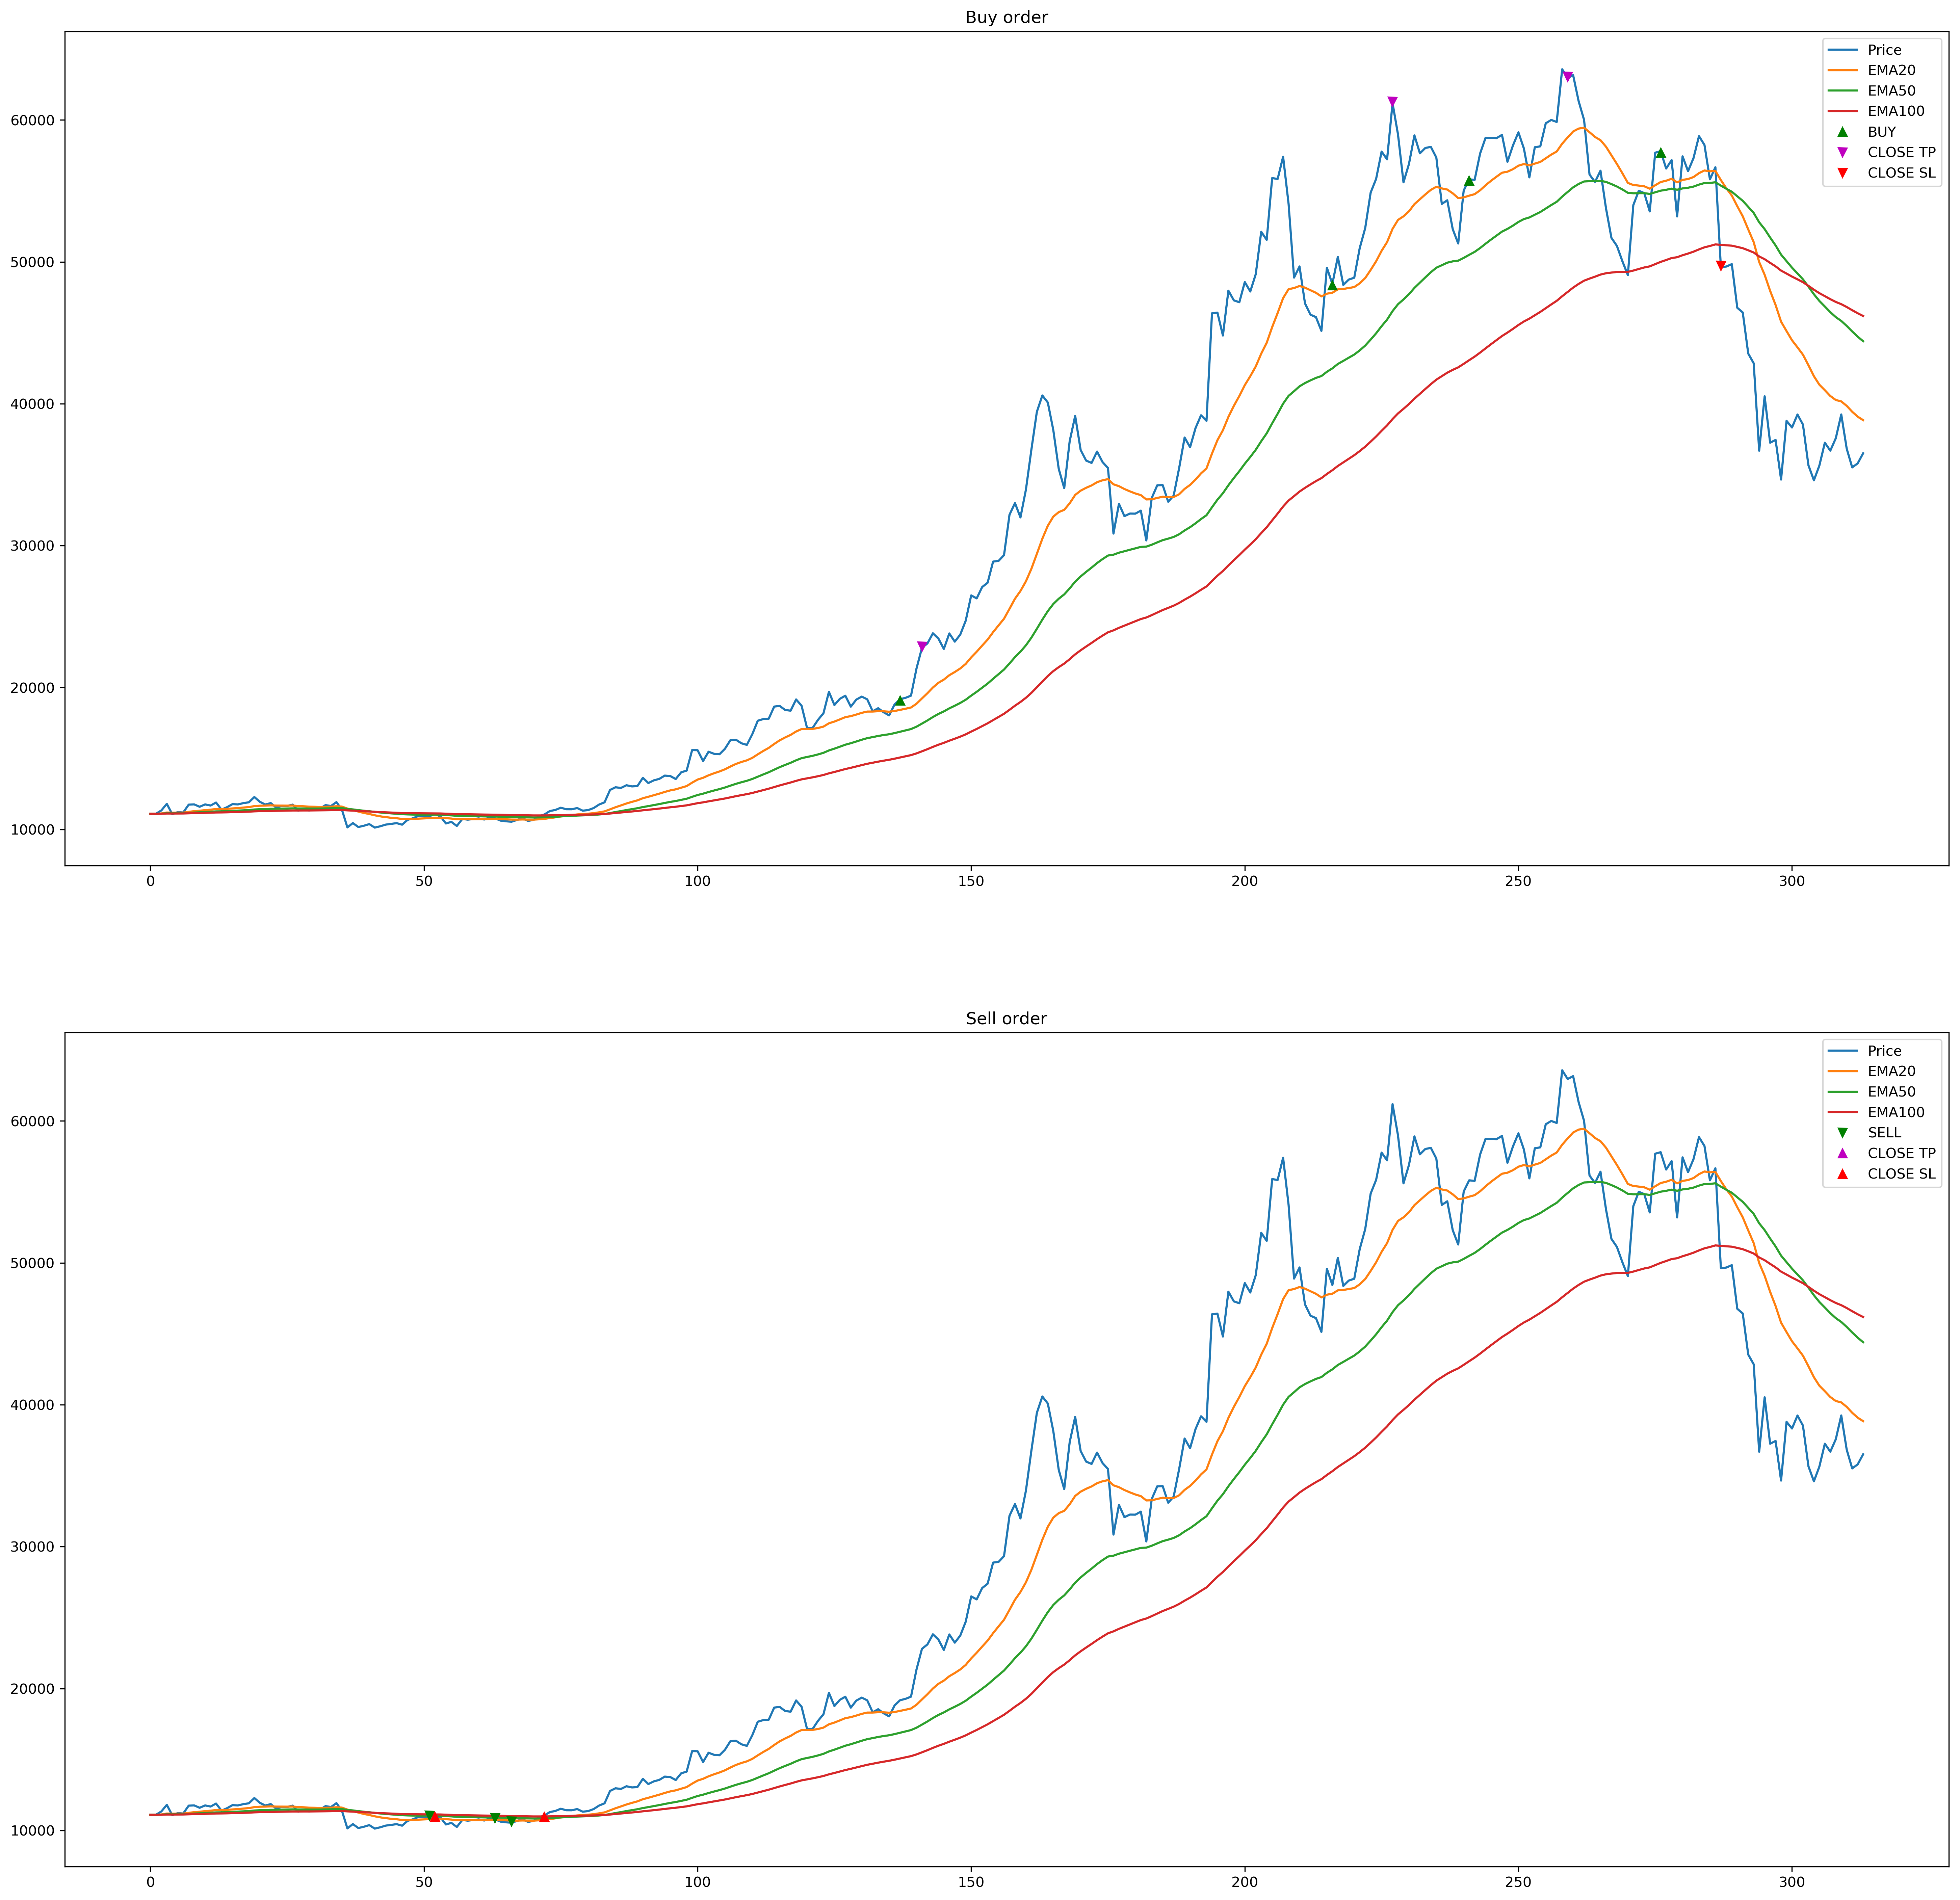

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(24, 24), dpi=300)

# Plotting prices Buy
ax = axs[0]
ax.plot(df.close, label='Price')
ax.plot(df.ema20, label='EMA20')
ax.plot(df.ema50, label='EMA50')
ax.plot(df.ema100, label='EMA100')
# data
buy = (trades.Action == "BUY")
buy_win = (trades.Action == "BUY") & (trades.Benef > 0)
buy_lose = (trades.Action == "BUY") & (trades.Benef < 0)
ax.plot(trades[buy].i, 
        df.close.iloc[trades[buy].i] - 100, 
        "^g", label='BUY')
ax.plot(trades[buy_win].i + trades[buy_win].Duration, 
        df.close.iloc[trades[buy_win].i + trades[buy_win].Duration] + 100, 
        "vm", label='CLOSE TP')
ax.plot(trades[buy_lose].i + trades[buy_lose].Duration, 
        df.close.iloc[trades[buy_lose].i + trades[buy_lose].Duration] + 100, 
         "vr", label='CLOSE SL')
ax.set_title("Buy order")
ax.legend()

# Plotting prices Sell
ax = axs[1]
ax.plot(df.close, label='Price')
ax.plot(df.ema20, label='EMA20')
ax.plot(df.ema50, label='EMA50')
ax.plot(df.ema100, label='EMA100')
# data
sell = (trades.Action == "SELL")
sell_win = (trades.Action == "SELL") & (trades.Benef > 0)
sell_lose = (trades.Action == "SELL") & (trades.Benef < 0)
ax.plot(trades[sell].i, 
        df.close.iloc[trades[sell].i] + 100, 
        "vg", label='SELL')
ax.plot(trades[sell_win].i + trades[sell_win].Duration, 
        df.close.iloc[trades[sell_win].i + trades[sell_win].Duration] - 100, 
        "^m", label='CLOSE TP')
ax.plot(trades[sell_lose].i + trades[sell_lose].Duration, 
        df.close.iloc[trades[sell_lose].i + trades[sell_lose].Duration] - 100, 
        "^r", label='CLOSE SL')
ax.set_title("Sell order")
ax.legend()

In [179]:
(trades.Action == "BUY") | (trades.Benef > 0)

0     False
1      True
2      True
3      True
4     False
      ...  
56    False
57     True
58     True
59    False
60    False
Length: 61, dtype: bool

In [177]:
(trades.Benef > 0)

0     False
1      True
2      True
3      True
4     False
      ...  
56    False
57     True
58     True
59    False
60    False
Name: Benef, Length: 61, dtype: bool

In [178]:
(trades.Action == "BUY")

0     False
1     False
2     False
3     False
4     False
      ...  
56    False
57    False
58    False
59    False
60    False
Name: Action, Length: 61, dtype: bool